In [12]:
import os

import click
from os.path import  join, isdir
from plan import Plan
from action import Action
from utils import load_from_folder
from multiprocess import Pool

def run_script(script: str):
    print(f'Running {script}')
    os.system(f'chmod +x {script}')
    os.system(script)


def clear_scripts_dir(scripts_path: str):
    if os.path.isdir(scripts_path):
        os.system(f'rm -r {scripts_path}')
    os.system(f'mkdir -p {scripts_path}')

In [ ]:
logger_dir = './logs/'
source_dir = '../datasets/logistics/optimal/plans_max-plan-dim=30_train_percentage=0.8'
os.makedirs(logger_dir, exist_ok=True)
test = True

Data load

In [24]:
splits = {}
train_plans = load_from_folder(source_dir,["train_plans"])
train_plans = train_plans[0]
val_plans = load_from_folder(source_dir,["val_plans"])
val_plans = val_plans[0]
test_plans = load_from_folder(source_dir,["test_plans"])
test_plans = test_plans[0]

splits["train_plans"] = train_plans
splits["val_plans"] = val_plans
splits["test_plans"] = test_plans


train_plans loaded from ../datasets/logistics/optimal/plans_max-plan-dim=30_train_percentage=0.8
val_plans loaded from ../datasets/logistics/optimal/plans_max-plan-dim=30_train_percentage=0.8
test_plans loaded from ../datasets/logistics/optimal/plans_max-plan-dim=30_train_percentage=0.8


Data analysis

In [26]:
print(f"Train plans: {len(train_plans)}")
print(f"Val plans: {len(val_plans)}")
print(f"Test plans: {len(test_plans)}")

Train plans: 38215
Val plans: 4776
Test plans: 4778


In [34]:
for split in splits:
    print(f"{split}: Number of plans: {len(splits[split])}")        

train_plans: Number of plans: 38215
val_plans: Number of plans: 4776
test_plans: Number of plans: 4778


In [ ]:
import matplotlib.pyplot as plt



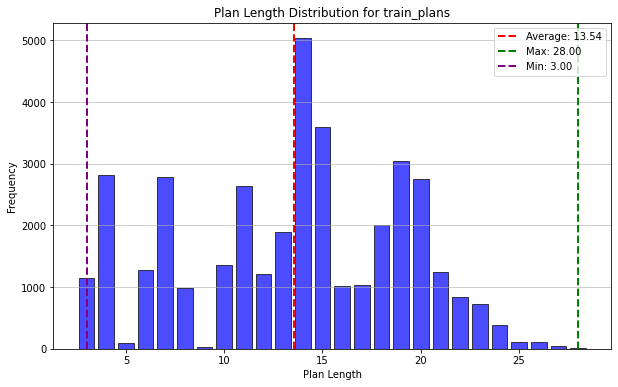

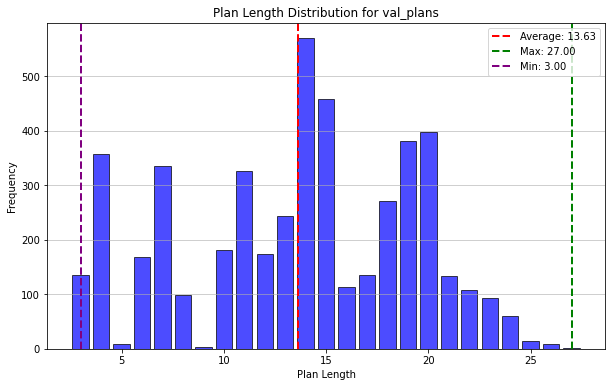

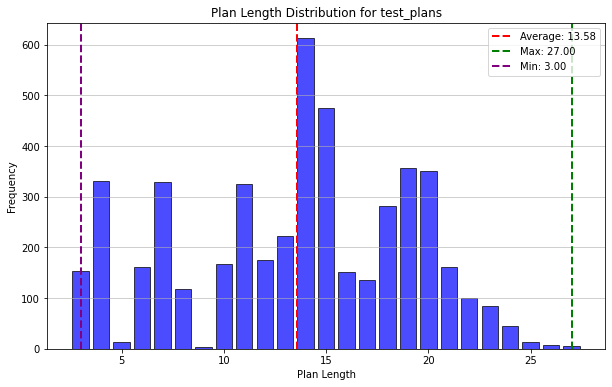

In [102]:
import numpy as np
    
for split, plans in splits.items():
    plan_lengths = [len(plan.actions) for plan in plans]
   
    avg_length_local = np.mean(plan_lengths)
    max_length_local = np.max(plan_lengths)
    min_length_local = np.min(plan_lengths)

    frequency = {}
    for length in plan_lengths:
        frequency[length] = frequency.get(length, 0) + 1
    plt.figure(figsize=(10, 6))
    plt.bar(frequency.keys(), frequency.values(), color='blue', alpha=0.7, edgecolor='black')
    plt.axvline(x=avg_length_local, color='red', linestyle='--', linewidth=2, label=f'Average: {avg_length_local:.2f}')
    plt.axvline(x=max_length_local, color='green', linestyle='--', linewidth=2, label=f'Max: {max_length_local:.2f}')
    plt.axvline(x=min_length_local, color='purple', linestyle='--', linewidth=2, label=f'Min: {min_length_local:.2f}')
    plt.legend()
    plt.title(f"Plan Length Distribution for {split}")
    plt.xlabel("Plan Length")
    plt.ylabel("Frequency")
    plt.grid(axis='y', alpha=0.75)
    plt.show()

In [ ]:
for split, plans in splits.items():
    print(f"Plan {plans[0].plan_name} for {split}:")
    for action in plans[0].actions:
        print(f"    {action.name}")
        print(f"        + : {action.positiveEffects}")
        print(f"        - : {action.negativeEffects}")
    print()
    

Plan /home/mchiari/state_embedding/dataset/logistics/optimal/xmls//xml-LPG-p062070.SOL for train_plans:
    LOAD-TRUCK OBJ77 TRU4 POS33
        + : ['in obj77 tru4']
        - : ['at obj77 pos33']
    DRIVE-TRUCK TRU3 POS55 APT2 CIT6
        + : ['at tru3 apt2']
        - : ['at tru3 pos55']
    DRIVE-TRUCK TRU1 POS21 POS11 CIT2
        + : ['at tru1 pos11']
        - : ['at tru1 pos21']
    LOAD-TRUCK OBJ22 TRU1 POS11
        + : ['in obj22 tru1']
        - : ['at obj22 pos11']
    LOAD-TRUCK OBJ21 TRU1 POS11
        + : ['in obj21 tru1']
        - : ['at obj21 pos11']
    DRIVE-TRUCK TRU1 POS11 APT4 CIT2
        + : ['at tru1 apt4']
        - : ['at tru1 pos11']
    UNLOAD-TRUCK OBJ22 TRU1 APT4
        + : ['at obj22 apt4']
        - : ['in obj22 tru1']
    DRIVE-TRUCK TRU1 APT4 POS21 CIT2
        + : ['at tru1 pos21']
        - : ['at tru1 apt4']
    UNLOAD-TRUCK OBJ21 TRU1 POS21
        + : ['at obj21 pos21']
        - : ['in obj21 tru1']
    DRIVE-TRUCK TRU4 POS33 APT6 CIT5
      